## Зависимости

In [ ]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

## Получение датасета

Функции

In [ ]:
# функция запроса api возвращающая json с информацией о фильмах
def get_kp_json(page):
  # ссылка на документацию https://api.kinopoisk.dev/documentation
  TOKEN = ''

  min_rating = 1 # минимальный рейтинг искомых фильмов
  max_rating = 10 # максимальный рейтинг искомых фильмов
  url_rating = f'&rating.kp={min_rating}-{max_rating}'

  min_votes = 50000 # минимальное количество оценок на кинопоиске
  max_votes = 9999999999 # максимальное количество оценок на кинопоиске
  url_votes = f'&votes.kp={min_votes}-{max_votes}'

  limit = 250 # максимальное количество фильмов за запрос (не более 250)
  url_base = f'https://api.kinopoisk.dev/v1.4/movie'
  url_params = f'?type=movie{url_rating}{url_votes}&limit={limit}&page={page}'

  headers = {'X-API-KEY': TOKEN}
  response = requests.get(url_base + url_params, headers=headers)

  print(f'-- status code: {response.status_code}')
  # код 200 - все ок
  # код 400 - запрашивается слишком много фильмов за раз
  # код 401 - проблема с токеном

  return response.json()


# функция для парсинга json с информацией о фильмах
def parse_kp_json(kp_json):
  info_list = []
  cols = ['name', 'type', 'year', 'movieLength', 'rating',
          'votes', 'genres', 'countries', 'ageRating']

  for movie in kp_json:
    info_list.append([movie[c] for c in cols])

  return pd.DataFrame(info_list, columns=cols)

Определение полного количества фильмов согласно параметрам и парсинг первого запроса

In [ ]:
curr_kp_json = get_kp_json(1)

movie_list = curr_kp_json['docs']
pages = curr_kp_json["pages"]
df_kp_0 = parse_kp_json(movie_list)

print(f'-  movies pulled: {len(movie_list)}')
print(f'-  total movies in json: {curr_kp_json["total"]}')
print(f'-  total pages in json: {pages}')

-- status code: 200
-  movies pulled: 250
-  total movies in json: 2620
-  total pages in json: 11


Парсинг всех остальных фильмов

In [ ]:
# парсинг остальных страниц с информацией о фильмах
for page in range(pages + 1):
  if page < 2: continue
  # преобразование полученной информации в датафрейм
  df_curr = parse_kp_json(get_kp_json(page)["docs"])
  # конкатенация полученного датафрейма с основным
  df_kp_0 = pd.concat([df_kp_0, df_curr], axis=0)\
  .reset_index().drop('index', axis=1)

-- status code: 200
-- status code: 200
-- status code: 200
-- status code: 200
-- status code: 200
-- status code: 200
-- status code: 200
-- status code: 200
-- status code: 200
-- status code: 200


In [ ]:
print(f'unique movies: {len(df_kp_0.name.drop_duplicates())}')
print(f'df length: {len(df_kp_0)}')
df_kp_0.head(3)

unique movies: 2571
df length: 2620


,name,type,year,movieLength,rating,votes,genres,countries,ageRating
0,1+1,movie,2011,112,"{'kp': 8.818, 'imdb': 8.5, 'filmCritics': 6.8,...","{'kp': 1881876, 'imdb': 909731, 'filmCritics':...","[{'name': 'драма'}, {'name': 'комедия'}, {'nam...",[{'name': 'Франция'}],18.0
1,Джентльмены,movie,2019,113,"{'kp': 8.563, 'imdb': 7.8, 'filmCritics': 6.5,...","{'kp': 1588115, 'imdb': 377723, 'filmCritics':...","[{'name': 'криминал'}, {'name': 'комедия'}, {'...","[{'name': 'США'}, {'name': 'Великобритания'}]",18.0
2,Волк с Уолл-стрит,movie,2013,180,"{'kp': 8.001, 'imdb': 8.2, 'filmCritics': 7.8,...","{'kp': 1239185, 'imdb': 1537134, 'filmCritics'...","[{'name': 'драма'}, {'name': 'криминал'}, {'na...",[{'name': 'США'}],18.0


Обработка столбцов с неотформатированными данными (оценка и голоса)

In [ ]:
df_rating_votes = pd.DataFrame()
for metric in ['rating', 'votes']:
  formatted_metric = []
  for m in df_kp_0[metric].tolist():
    formatted_metric.append([m['kp'], m['imdb']])

  df_current = pd.DataFrame(formatted_metric,
                            columns=[f'{metric}_kp', f'{metric}_imdb'])

  df_rating_votes = pd.concat([df_rating_votes, df_current], axis=1)

df_rating_votes.head(3)

,rating_kp,rating_imdb,votes_kp,votes_imdb
0,8.818,8.5,1881876,909731
1,8.563,7.8,1588115,377723
2,8.001,8.2,1239185,1537134


Обработка столбцов с неотформатированными данными (жанры и страны производства)

In [ ]:
list_genres_countries, all_genres, all_countries = [], [], []
for metric in ['genres', 'countries']:
  formatted_metric = []
  for m in df_kp_0[metric].tolist():
    item_list = []
    for item in m:
      item_list.append(item['name'])

      # сбор списков всех стран и жанров
      if metric == 'genres':
        all_genres.append(item['name'])
      else:
        all_countries.append(item['name'])

    formatted_metric.append(item_list)
  list_genres_countries.append(formatted_metric)

all_genres = list(set(all_genres))
all_countries = list(set(all_countries))

# кодировка жанров (One Hot Encoding)
list_genres = []
for movie_genre in list_genres_countries[0]:
  current_row = []
  for g in all_genres:
    current_row.append(int(g in movie_genre))

  list_genres.append(current_row)

df_genres = pd.DataFrame(list_genres, columns=all_genres)

# кодировка стран (One Hot Encoding)
list_countries = []
for movie_country in list_genres_countries[1]:
  current_row = []
  for c in all_countries:
    current_row.append(int(c in movie_country))

  list_countries.append(current_row)

df_countries = pd.DataFrame(list_countries, columns=all_countries)

Объединение всех датафреймов в единый датасет

In [ ]:
df_kp = pd.concat([df_kp_0[['name', 'year', 'movieLength']],
                   df_rating_votes,
                   df_genres,
                   df_countries,
                   df_kp_0['ageRating']], axis=1)

print(f'Full df length: {len(df_kp)}\n\n')
df_kp.head(3)

Full df length: 2620




,name,year,movieLength,rating_kp,rating_imdb,votes_kp,votes_imdb,фэнтези,военный,музыка,...,Россия,Беларусь,Аргентина,Канада,Багамы,Саудовская Аравия,Марокко,США,Турция,ageRating
0,1+1,2011,112,8.818,8.5,1881876,909731,0,0,0,...,0,0,0,0,0,0,0,0,0,18.0
1,Джентльмены,2019,113,8.563,7.8,1588115,377723,0,0,0,...,0,0,0,0,0,0,0,1,0,18.0
2,Волк с Уолл-стрит,2013,180,8.001,8.2,1239185,1537134,0,0,0,...,0,0,0,0,0,0,0,1,0,18.0


Сохранение датасета в виде csv файла

In [ ]:
df_kp.to_csv('kp_movies_info.csv', index=False)

## Анализ данных

Чтение датасета

In [ ]:
df = pd.read_csv('kp_movies_info.csv')
df = df.dropna().reset_index()
df_kp = df.drop(['name', 'index'], axis=1)
movie_names = df['name']

print(f'Full df length: {len(df_kp)}\n\n')
df_kp.head(10)

Full df length: 2586




,year,movieLength,rating_kp,rating_imdb,votes_kp,votes_imdb,фэнтези,военный,музыка,семейный,...,Россия,Беларусь,Аргентина,Канада,Багамы,Саудовская Аравия,Марокко,США,Турция,ageRating
0,2011,112,8.818,8.5,1881876,909731,0,0,0,0,...,0,0,0,0,0,0,0,0,0,18.0
1,2019,113,8.563,7.8,1588115,377723,0,0,0,0,...,0,0,0,0,0,0,0,1,0,18.0
2,2013,180,8.001,8.2,1239185,1537134,0,0,0,0,...,0,0,0,0,0,0,0,1,0,18.0
3,1997,100,8.308,7.8,1221203,23800,0,0,0,0,...,1,0,0,0,0,0,0,0,0,18.0
4,2021,119,7.607,7.1,1198952,200222,0,0,0,0,...,0,0,0,0,0,0,0,1,0,18.0
5,1990,103,8.275,7.7,1119073,628492,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0.0
6,2009,162,7.974,7.9,1047918,1368165,0,0,0,0,...,0,0,0,0,0,0,0,1,0,12.0
7,1994,142,9.109,9.3,996161,2833008,0,0,0,0,...,0,0,0,0,0,0,0,1,0,16.0
8,2019,130,8.105,7.9,991787,750725,0,0,0,0,...,0,0,0,0,0,0,0,1,0,18.0
9,1973,88,8.787,8.2,969334,18001,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6.0


Получение новых компонент с помощью t-SNE

In [ ]:
tsne = TSNE(n_components=2)

df_kp_tsne = pd.DataFrame(tsne.fit_transform(df_kp),
                          columns=['comp_1', 'comp_2'])

Визуализация датасета в новых компонентах

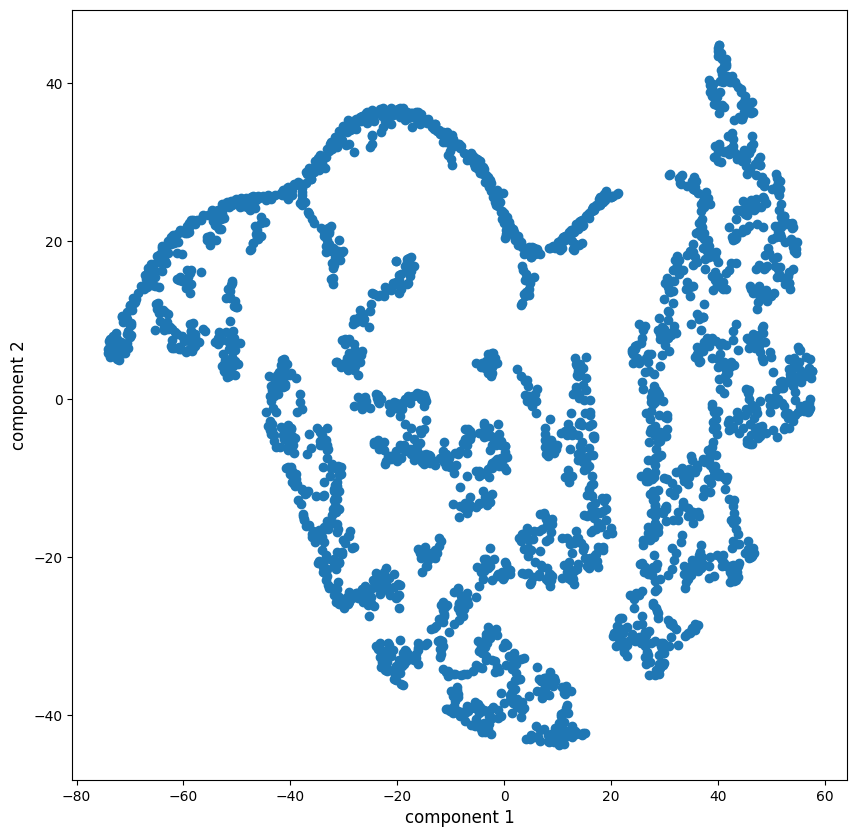

In [ ]:
plt.figure(figsize=(10,10))

plt.scatter(x=df_kp_tsne['comp_1'],
            y=df_kp_tsne['comp_2'])

plt.xlabel('component 1', fontsize=12)
plt.ylabel('component 2', fontsize=12)
plt.show()

Нормализация датасета

In [ ]:
scaler = MinMaxScaler()

scaleble_columns = df_kp.columns[:6].tolist() + [df_kp.columns[-1]]

df_kp_scaled = pd.DataFrame(scaler.fit_transform(df_kp[scaleble_columns]),
                            columns=scaleble_columns)

df_kp_scaled = pd.concat([df_kp_scaled, df_kp[df_kp.columns[6:-1]]], axis=1)
df_kp_scaled.head(3)

,year,movieLength,rating_kp,rating_imdb,votes_kp,votes_imdb,ageRating,фэнтези,военный,музыка,...,Япония,Россия,Беларусь,Аргентина,Канада,Багамы,Саудовская Аравия,Марокко,США,Турция
0,0.869565,0.178010,0.963611,0.913978,1.000000,0.321118,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.956522,0.179756,0.931724,0.838710,0.839637,0.133329,1.0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0.891304,0.296684,0.861448,0.881720,0.649158,0.542580,1.0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


Получение новых компонент с помощью t-SNE для нормализованного датасета

In [ ]:
tsne = TSNE(n_components=2)

df_kp_tsne = pd.DataFrame(
    tsne.fit_transform(df_kp_scaled),
    columns=['comp_1', 'comp_2'])

Визуализация нормализованных данных в новых компонентах

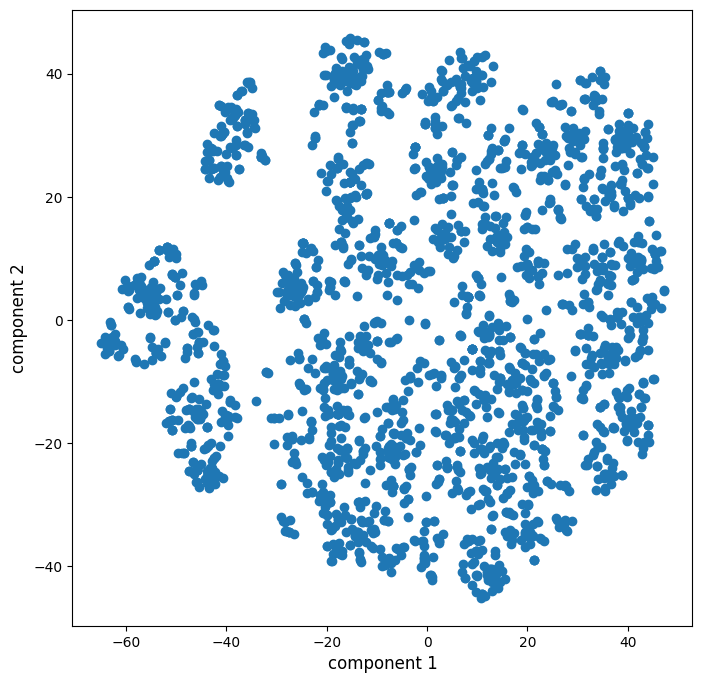

In [ ]:
plt.figure(figsize=(8,8))

plt.scatter(x=df_kp_tsne['comp_1'],
            y=df_kp_tsne['comp_2'])

plt.xlabel('component 1', fontsize=12)
plt.ylabel('component 2', fontsize=12)
plt.show()

Выбор значения перплексии t-SNE

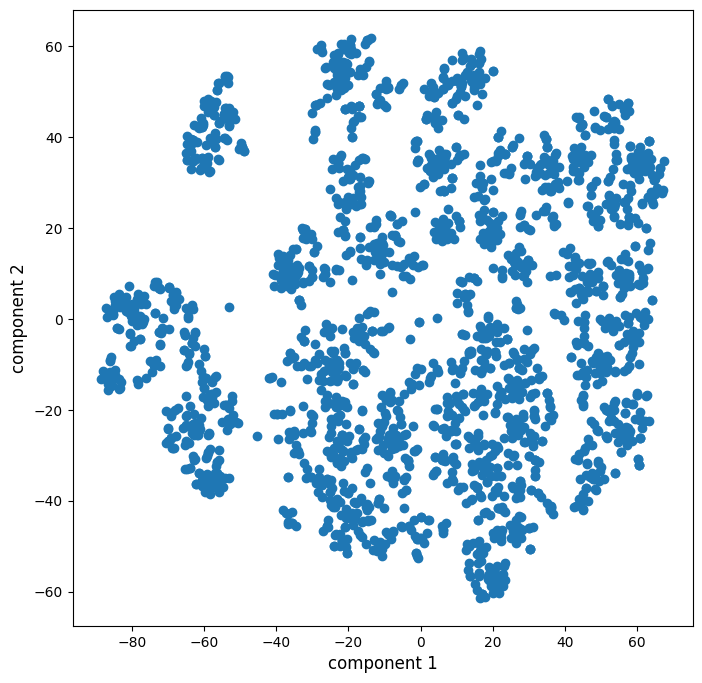

In [ ]:
tsne = TSNE(n_components=2, perplexity=25, n_iter=5000)

df_kp_tsne = pd.DataFrame(
    tsne.fit_transform(df_kp_scaled),
    columns=['comp_1', 'comp_2'])

plt.figure(figsize=(8,8))

plt.scatter(x=df_kp_tsne['comp_1'],
            y=df_kp_tsne['comp_2'])

plt.xlabel('component 1', fontsize=12)
plt.ylabel('component 2', fontsize=12)
plt.show()

Предварительный расчет параметров DBSCAN

In [ ]:
sil_scores_0 = []
eps_list = [(n + 1) / 10 for n in range(300)]

for eps in eps_list:
  for min in range(3, 101):

    dbscan = DBSCAN(eps=eps, min_samples=int(min))
    data_predict = dbscan.fit_predict(df_kp_tsne)

    try:
      sil_scores_0.append([eps,
                           min,
                           len(set(data_predict)) - int(-1 in data_predict),
                           sum([int(p==-1) for p in data_predict]) / len(data_predict),
                           ])
    except:
      continue

df_sil_scores = pd.DataFrame(sil_scores_0, columns=['eps',
                                                    'min_samples',
                                                    'num_clusters',
                                                    'part_anomalies',
                                                    ])

df_sil_scores.head(3)

,eps,min_samples,num_clusters,part_anomalies
0,0.1,3,64,0.924207
1,0.1,4,4,0.993813
2,0.1,5,0,1.000000


Предварительный отбор пар параметров для DBSCAN

In [ ]:
df_test = df_sil_scores.loc[(df_sil_scores.part_anomalies<0.01)\
                            & (df_sil_scores.num_clusters<20)\
                            & (df_sil_scores.num_clusters>3)\
                            & (df_sil_scores.part_anomalies>0)]\
                            .reset_index().drop('index', axis=1)

print(f'Amount of parameter pairs: {len(df_test)}')
df_test.head(3)

Amount of parameter pairs: 960


,eps,min_samples,num_clusters,part_anomalies
0,4.0,3,18,0.006187
1,4.0,4,17,0.007347
2,4.0,5,18,0.009281


Расчет коэффициентов силуэта для полученных пар параметров DBSCAN

In [ ]:
sil_scores = []
for eps, min in zip(df_test['eps'], df_test['min_samples']):

  dbscan = DBSCAN(eps=eps, min_samples=int(min))
  data_predict = dbscan.fit_predict(df_kp_tsne)

  try:
    sil_scores.append([eps,
                       min,
                       len(set(data_predict)) - int(-1 in data_predict),
                       sum([int(p==-1) for p in data_predict]) / len(data_predict),
                       silhouette_score(df_kp_tsne, data_predict)
                       ])
  except:
    continue

df_sil_scores = pd.DataFrame(sil_scores, columns=['eps',
                                                  'min_samples',
                                                  'num_clusters',
                                                  'part_anomalies',
                                                  'sil_score'
                                                  ])

df_sil_scores.head(3)

,eps,min_samples,num_clusters,part_anomalies,sil_score
0,4.0,3,18,0.006187,-0.060321
1,4.0,4,17,0.007347,-0.004089
2,4.0,5,18,0.009281,0.106847


Отбор пар параметров DBSCAN с максимальными значениями коэффициентов силуэта

In [ ]:
df_sil_scores.sort_values(by='sil_score', ascending=False).head(3)

,eps,min_samples,num_clusters,part_anomalies,sil_score
218,6.7,20,6,0.008894,0.322116
239,7.0,22,5,0.008507,0.318286
480,10.6,71,7,0.008507,0.314505


Визуализация кластеров

Num of clusters: 7



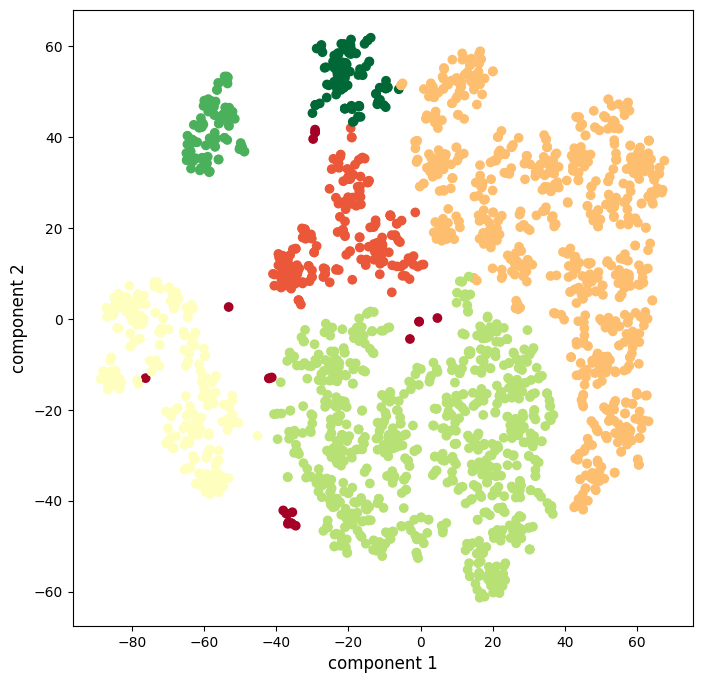

In [ ]:
dbscan = DBSCAN(eps=6.7, min_samples=20)
data_predict = dbscan.fit_predict(df_kp_tsne)

print(f'Num of clusters: {len(set(data_predict))}\n')

plt.figure(figsize=(8,8))

plt.scatter(x=df_kp_tsne['comp_1'],
            y=df_kp_tsne['comp_2'],
            c=data_predict,
            cmap='RdYlGn')

plt.xlabel('component 1', fontsize=12)
plt.ylabel('component 2', fontsize=12)
plt.show()

Сохранение датасета с полученными кластерами

In [ ]:
df_labeled = df
df_labeled['label'] = data_predict
df_labeled['tsne_comp_1'] = df_kp_tsne['comp_1']
df_labeled['tsne_comp_2'] = df_kp_tsne['comp_2']

df_labeled.to_csv('kp_movies_info_labeled.csv', index=False)

df_labeled.head(3)

,index,name,year,movieLength,rating_kp,rating_imdb,votes_kp,votes_imdb,фэнтези,военный,...,Канада,Багамы,Саудовская Аравия,Марокко,США,Турция,ageRating,label,tsne_comp_1,tsne_comp_2
0,0,1+1,2011,112,8.818,8.5,1881876,909731,0,0,...,0,0,0,0,0,0,18.0,0,-20.751486,24.103422
1,1,Джентльмены,2019,113,8.563,7.8,1588115,377723,0,0,...,0,0,0,0,1,0,18.0,1,16.989384,22.616327
2,2,Волк с Уолл-стрит,2013,180,8.001,8.2,1239185,1537134,0,0,...,0,0,0,0,1,0,18.0,0,-4.165424,9.428358


## Интерпритация полученных кластеров

Чтение датасета с полученными кластерами

In [ ]:
df_labeled = pd.read_csv('/content/kp_movies_info_labeled.csv')
df_labeled.head(3)

,index,name,year,movieLength,rating_kp,rating_imdb,votes_kp,votes_imdb,фэнтези,военный,...,Канада,Багамы,Саудовская Аравия,Марокко,США,Турция,ageRating,label,tsne_comp_1,tsne_comp_2
0,0,1+1,2011,112,8.818,8.5,1881876,909731,0,0,...,0,0,0,0,0,0,18.0,0,-20.751486,24.103422
1,1,Джентльмены,2019,113,8.563,7.8,1588115,377723,0,0,...,0,0,0,0,1,0,18.0,1,16.989384,22.616327
2,2,Волк с Уолл-стрит,2013,180,8.001,8.2,1239185,1537134,0,0,...,0,0,0,0,1,0,18.0,0,-4.165424,9.428358


Визуализация кластеров

Num of clusters: 7



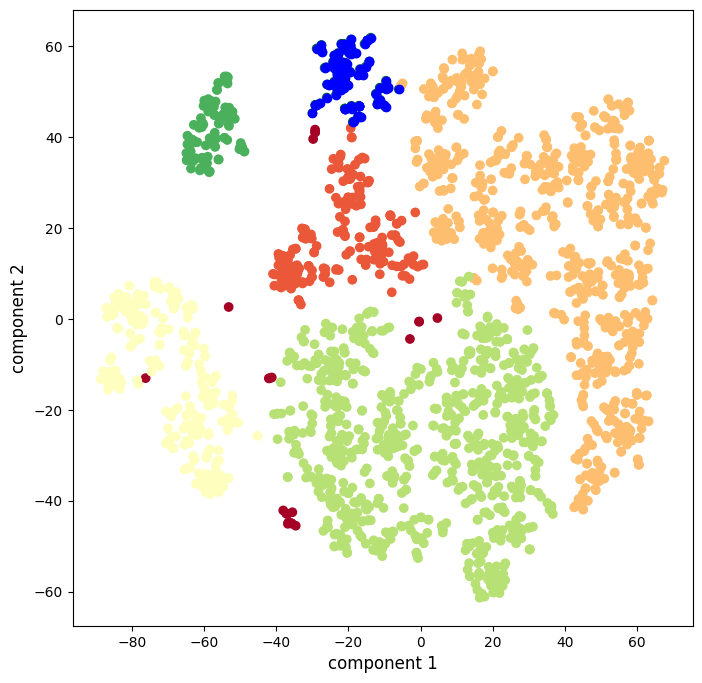

In [ ]:
print(f'Num of clusters: {len(set(df_labeled.label))}\n')

plt.figure(figsize=(8,8))

plt.scatter(x=df_labeled['tsne_comp_1'],
            y=df_labeled['tsne_comp_2'],
            c=df_labeled['label'],
            cmap='RdYlGn')

df_labeled_1 = df_labeled[df_labeled.label==5]
plt.scatter(x=df_labeled_1['tsne_comp_1'],
            y=df_labeled_1['tsne_comp_2'],
            c='b')

plt.xlabel('component 1', fontsize=12)
plt.ylabel('component 2', fontsize=12)

plt.show()

In [ ]:
def interpret_label(df_, label_):
  # получение информации о выборке
  df_lbl = df_[df_.label==label_]
  df_len = len(df_lbl)

  print(f'Интерпритация кластера: {label_}')
  print(f' - Кол-во фильмов: {df_len} ({(df_len/len(df_))*100:.2f} % от всех)')

  # получение информации о жанрах
  lbl_cols_genres = df_lbl.columns[8:31]
  genres = dict([(df_lbl[g].sum(), g) for g in lbl_cols_genres])
  top_genres = [f'{genres[k]}: {(k/df_len):.2f}' for k in sorted(genres.keys())[-1:-4:-1]]

  print(f' - Топ жанры: {" | ".join(top_genres)}')

  # получение информации о странах
  lbl_cols_country = df_lbl.columns[31:-4]
  countries = dict([(df_lbl[c].sum(), c) for c in lbl_cols_country])
  top_countries = [f'{countries[k]}: {(k/df_len):.2f}' for k in sorted(countries.keys())[-1:-4:-1]]

  print(f' - Топ стран: {" | ".join(top_countries)}')

In [ ]:
for l in list(set(df_labeled.label)):
  interpret_label(df_labeled, l)
  print('')

Интерпритация кластера: 0
 - Кол-во фильмов: 222 (8.58 % от всех)
 - Топ жанры: комедия: 0.99 | драма: 0.82 | мелодрама: 0.41
 - Топ стран: США: 0.67 | Франция: 0.28 | Великобритания: 0.14

Интерпритация кластера: 1
 - Кол-во фильмов: 884 (34.18 % от всех)
 - Топ жанры: боевик: 0.78 | приключения: 0.43 | триллер: 0.40
 - Топ стран: США: 0.94 | Великобритания: 0.20 | Канада: 0.11

Интерпритация кластера: 2
 - Кол-во фильмов: 326 (12.61 % от всех)
 - Топ жанры: драма: 0.48 | комедия: 0.43 | боевик: 0.17
 - Топ стран: Россия: 0.98 | Германия: 0.02 | Беларусь: 0.01

Интерпритация кластера: 3
 - Кол-во фильмов: 904 (34.96 % от всех)
 - Топ жанры: драма: 0.77 | триллер: 0.44 | детектив: 0.23
 - Топ стран: США: 0.83 | Великобритания: 0.26 | Франция: 0.14

Интерпритация кластера: 4
 - Кол-во фильмов: 110 (4.25 % от всех)
 - Топ жанры: комедия: 0.54 | драма: 0.53 | мелодрама: 0.42
 - Топ стран: СССР: 1.00 | Швеция: 0.01 | Турция: 0.00

Интерпритация кластера: 5
 - Кол-во фильмов: 117 (4.52 % от

In [ ]:
df_anomalies = df_labeled[df_labeled.label==-1]
df_len = len(df_anomalies)

lbl_cols_country = df_anomalies.columns[31:-4]
countries = [df_anomalies[c].sum() for c in lbl_cols_country]

lbl_cols_genres = df_anomalies.columns[8:31]
genres = [df_anomalies[c].sum() for c in lbl_cols_genres]

df_anomalies.head(3)

,index,name,year,movieLength,rating_kp,rating_imdb,votes_kp,votes_imdb,фэнтези,военный,...,Канада,Багамы,Саудовская Аравия,Марокко,США,Турция,ageRating,label,tsne_comp_1,tsne_comp_2
80,80,Паразиты,2019,131,8.013,8.5,572313,911440,0,0,...,0,0,0,0,0,0,18.0,-1,-42.033380,-13.101397
184,184,Укрощение строптивого,1980,107,8.396,7.6,406649,9345,0,0,...,0,0,0,0,0,0,18.0,-1,-29.205275,40.995250
439,439,Жизнь прекрасна,1997,116,8.624,8.6,245587,730314,0,1,...,0,0,0,0,0,0,12.0,-1,-29.755283,39.535410


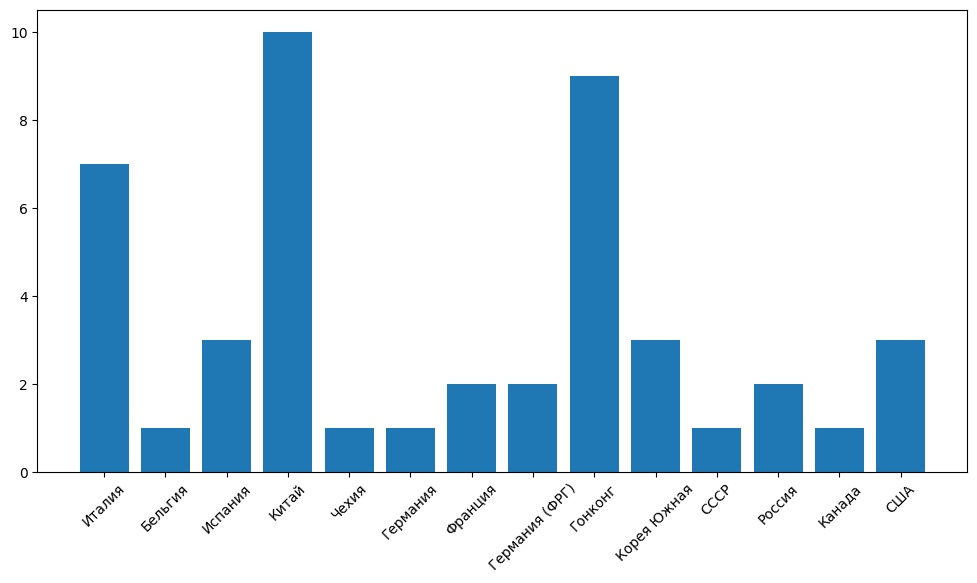

In [ ]:
df_anom_countries = pd.DataFrame([lbl_cols_country, countries],
                                 index=['country', 'freq']).T

df_anom_countries = df_anom_countries[df_anom_countries.freq>0]


plt.figure(figsize=(12,6))

plt.bar(df_anom_countries.country, df_anom_countries.freq)

plt.xticks(rotation=45)

plt.show()

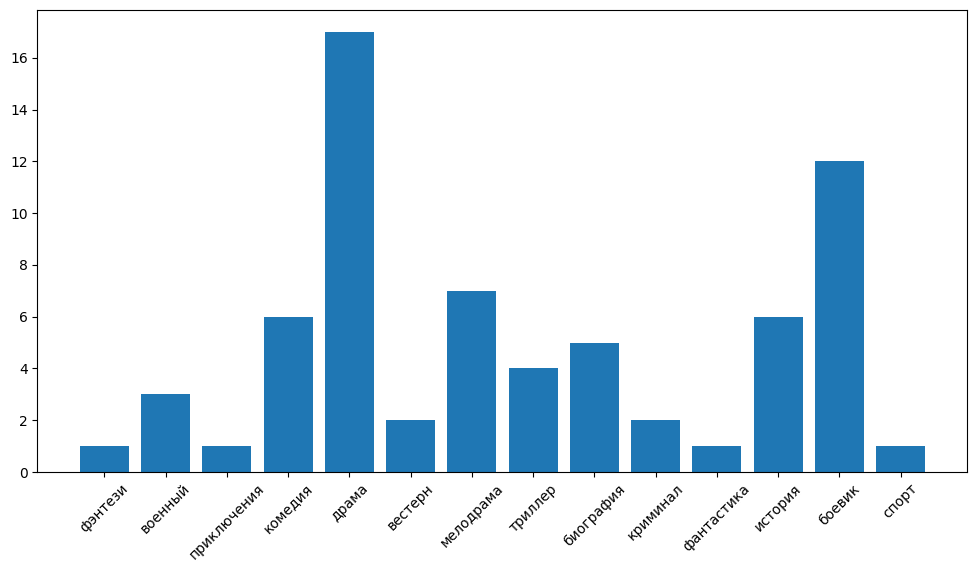

In [ ]:
df_anom_genres = pd.DataFrame([lbl_cols_genres, genres],
                              index=['genre', 'freq']).T

df_anom_genres = df_anom_genres[df_anom_genres.freq>0]


plt.figure(figsize=(12,6))

plt.bar(df_anom_genres.genre, df_anom_genres.freq)

plt.xticks(rotation=45)

plt.show()

In [ ]:
print(f'Rating KP mean: {np.mean(df_anomalies.rating_kp)}')
print(f'Rating KP median: {np.median(df_anomalies.rating_kp)}')

Rating KP mean: 7.839478260869564
Rating KP median: 7.926
